In [ ]:
# 这是一个用来得到ec的精细话数据的脚本

# 数据类型
1. vis 
2. uv_10
3. tmax
4. tmin
5. tcc 
6. t2
7. skt
8. lsp(大尺度降水)
9. conv(对流降水)


# 核心的算法的程序

In [10]:
%%time
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
import datetime

class ec_data_point:
    def __init__(self, select_time,select_type,select_lat,select_lon): 
        # self.var_list = ['vis','u10','v10','tmax2','tmin2','tcc','t2','skt','lsp','cp']
        self.var_list = ['u10','v10','tcc','t2','skt','lsp','cp','tp','r'] # 风向风速、云量、温度、tp（总降水）、相对湿度
        self.data = { }
        self.read_data()
    # 创建对象读取io的核心代码####################################################################
    def regrid_data(self,data):
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.8, 29.5, 0.05)),
                "lon": (["lon"], np.arange(120, 122, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    def read_data(self):
        file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 
        f = xr.open_mfdataset(file_path, parallel=False)
        # 列表数据--
        u10 = f.u10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        u10 =  u10.swap_dims({'latS':'lat','lonS':'lon'})
        v10 = f.v10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        v10 =  v10.swap_dims({'latS':'lat','lonS':'lon'})
        tcc = f.tcc.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        tcc =  tcc.swap_dims({'latS':'lat','lonS':'lon'})
        t2 = f.t2.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        t2 =  t2.swap_dims({'latS':'lat','lonS':'lon'})
        skt = f.skt.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        skt =  skt.swap_dims({'latS':'lat','lonS':'lon'})
        lsp = f.lsp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        lsp =  lsp.swap_dims({'latS':'lat','lonS':'lon'})
        cp = f.cp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        cp =  cp.swap_dims({'latS':'lat','lonS':'lon'})    
        tp = f.tp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        tp =  tp.swap_dims({'latS':'lat','lonS':'lon'}) 
        r = f.r.sel(lev=1000,lonP=slice(120,122),latP=slice(29.5,27.8)) # ！！！如果经纬度放大就会报错。。。
        r =  r.swap_dims({'latP':'lat','lonP':'lon'})
        r['lon'] = r['lonP']
        r['lat'] = r['latP']  
        # print(tp,r)
        # 空间插值----------------------------------
        # ----------------------------------------
        # ----------------------------------------
        # 此处为空间插值函数0.05
        grid_u10 = self.regrid_data(u10)
        grid_v10 = self.regrid_data(v10)
        grid_tcc = self.regrid_data(tcc)
        grid_t2 = self.regrid_data(t2)
        grid_skt = self.regrid_data(skt)
        grid_lsp = self.regrid_data(lsp)
        grid_cp = self.regrid_data(cp)
        grid_tp = self.regrid_data(tp)
        grid_r = r#self.regrid_data(r)
        # 数据的重新加载
        
        self.data['u10'] = grid_u10
        self.data['v10'] = grid_v10
        self.data['tcc'] = grid_tcc
        self.data['t2'] = grid_t2
        self.data['skt'] = grid_skt
        self.data['lsp'] = grid_lsp
        self.data['cp'] = grid_cp    
        self.data['tp'] = grid_tp 
        self.data['r'] = grid_r 
        # print(grid_vis.sel(lon=121.5, lat=28.5,method='nearest'))    
    def interp1d_data(self,data):
        ''' 将get_data和get_single_data的数据进行时间插值'''
        date = data.index.tolist()
        value = data.tolist()
        d = pd.DataFrame()
        d['date'] = pd.to_datetime(date)
        d['val'] = value
        helper = pd.DataFrame({'date': pd.date_range(d['date'].min(), d['date'].max(), freq='H')})
        d = pd.merge(helper, d, on='date', how='left').sort_values('date')
        d['val'] = d['val'].interpolate(method='linear')        
        return d['val'].tolist() 
    # 处理所有数据的核心data #############################################################################################################
    def comput_all_data(self):
        '''用于计算所有数据的核心代码
        1.依据step 返回single_data
        2.依据step 返回曲线图的data 4个list 一个字典list
        '''
        print("返回single_data")
    # 以下为处理html表格的核心代码######################################################################################################################
    #  1. 计算超出指定日期的时间段数
    def time_point_len(self,times,step):
        start = str(times[0:10] + ' 00:00:00')
        t_start =datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        end = str(times+':00')
        t_end =datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
        timedelta = (t_end - t_start).seconds
        hours = timedelta/3600
        if step == 'hours':
            if hours <= 6:
                step_len = 0
            elif hours >6 and hours <= 12:
                step_len = 1
            elif hours >12 and hours <= 18:
                step_len = 2
            elif hours >18 and hours <= 24:
                step_len = 3
            return step_len
        elif step == '3hours':
            if hours <= 3:
                step_len = 0
            elif hours >3 and hours <= 6:
                step_len = 1
            elif hours >6 and hours <= 9:
                step_len = 2
            elif hours >9 and hours <= 12:
                step_len = 3
            elif hours >12 and hours <= 15:
                step_len = 4
            elif hours >15 and hours <= 18:
                step_len = 5
            elif hours >18 and hours <= 21:
                step_len = 6
            elif hours >21 and hours <= 24:
                step_len = 7   
            return step_len
        else:
            if hours <= 6:
                step_len = 0
            elif hours >6 and hours <= 12:
                step_len = 1
            elif hours >12 and hours <= 18:
                step_len = 2
            elif hours >18 and hours <= 24:
                step_len = 3
            return step_len  
    def return_dates_step(self):
        '''用于返回dates 和start_len,end_len'''
        # 起始时间
        start_day = '2022-04-18 00:00'
        end_day = '2022-04-22 13:00'
        # EC数据
        single_point_data = {
            'wind_speed':[i for i in range(241)],
            'wind_dir':[i for i in range(241)],
            'tcc':[i for i in range(241)],
            'skt':[i for i in range(241)],
            't2':[i for i in range(241)],
            'lsp':[i for i in range(241)],
            'cp':[i for i in range(241)],
            'tp':[i for i in range(241)],
            'r':[i for i in range(241)]
            
        }
        time_data = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
        data_index = [i for i in range(241) ]
        ts = pd.Series(data_index, time_data)
        start_len = self.time_point_len(start_day,step)
        end_len = self.time_point_len(end_day,step)
        # 计算日期
        dates = []
        dt = datetime.datetime.strptime(start_day, "%Y-%m-%d")
        date = start_day[:]
        while date <= end_day:
            dates.append(date)
            dt = dt + datetime.timedelta(1)
            date = dt.strftime("%Y-%m-%d")
        return dates,start_len,end_len  
    def return_timestep(self,dates,step,start_len,end_len):
        step_data = []
        if step == 'hours':
            # 6是每段时间的个数
            day_step = ['凌晨','上午','下午','晚上']
            step_data_num = 6
            step_list = [
                ['00:00~01:00','01:00~02:00','02:00~03:00','03:00~04:00','04:00~05:00','05:00~06:00'],
                ['06:00~07:00','07:00~08:00','08:00~09:00','09:00~10:00','10:00~11:00','11:00~12:00'],
                ['12:00~13:00','13:00~14:00','14:00~15:00','15:00~16:00','16:00~17:00','17:00~18:00'],
                ['18:00~19:00','19:00~20:00','20:00~21:00','21:00~22:00','22:00~23:00','23:00~24:00']
            ]
        elif step == '3hours':
            step_data_num = 1
            step_list = [
                ['00:00~03:00'],['03:00~06:00'],['06:00~09:00'],['09:00~12:00'],['12:00~15:00'],['15:00~18:00'],['18:00~21:00'],['21:00~24:00']   
            ]
        else:
            step_data_num = 1
            step_list = [
                ['凌晨'],['上午'],['下午'],['晚上']   
            ]
        # day_list
        if step != 'hours':
            day_list = [(i[5:7] + '月' + i[8:10] + '日') for i in dates]
        else:
            day_list = []
        for i in range(len(dates)):
            start_date , start_index = dates[i],ts[dates[i]]
            if i == 0: 
                # 第一天的数据         
                if step == 'hours':
                    # 计算天的段数
                    day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                    start_day_list = [day_str + i for i in day_step ]
                    day_list.extend(start_day_list[start_len:]) 
                    len_max = 4
                    for start_num in range(len_max-start_len):
                        single_step_data = {}   
                        single_step_data['step_list'] = step_list[(start_num+start_len)]
                        #  6是每段时间的个数
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):   
                            #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)
                elif step == '3hours':
                    len_max = 8
                    for start_num in range(len_max-start_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[(start_num+start_len)]   
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):   
                            #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*3  + step_num ])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)
                else:
                    len_max = 4  
                    for start_num in range(len_max-start_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[(start_num+start_len)]   
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*6  + step_num ])
                            appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*6  + step_num ])
                            appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*6  + step_num ])
                            appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*6  + step_num ])    
                            appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*6  + step_num ])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)      
            elif i ==len(dates)-1:    
                # 最后一天的数据
                if step == 'hours':
                    # 最后一天的day
                    day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                    end_day_list = [day_str + i for i in day_step ]
                    day_list.extend(end_day_list[:end_len]) 
                    for end_num in range(end_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[end_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (end_num)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)         
                        step_data.append(single_step_data)
                elif step == '3hours':
                    for end_num in range(end_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[end_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (end_num)*3  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (end_num)*3  + step_num])
                            single_step_data['step_data'].append(appen_data)                                    
                        step_data.append(single_step_data)
                else:
                    for end_num in range(end_len):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[end_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (end_num)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (end_num)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)         
                        step_data.append(single_step_data)
            else:
                # 中间天
                if step == 'hours':
                    # 添加 数据
                    day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                    middle_day_list = [day_str + i for i in day_step ]
                    day_list.extend(middle_day_list[:]) 
                    for middle_num in range(len_max):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[middle_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)         
                        step_data.append(single_step_data)
                elif step == '3hours':
                    for middle_num in range(len_max):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[middle_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num):   
                            #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*3  + step_num ])
                            appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*3  + step_num ])
                            single_step_data['step_data'].append(appen_data)
                        step_data.append(single_step_data)
                else:
                    for middle_num in range(len_max):
                        single_step_data = {}
                        single_step_data['step_list'] = step_list[middle_num]
                        single_step_data['step_data'] = []
                        for step_num in range(step_data_num): 
                            appen_data = []
                            appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*6  + step_num])
                            appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*6  + step_num])
                            single_step_data['step_data'].append(appen_data)        
                        step_data.append(single_step_data)
        data = {
            'day':day_list,
            'time_step':step_data
        }
        return data
    
    def decode_html_table(self):
        # 用来解析数据并返回表格的html数据
        # 日期、间隔
        step = 'prehours'# 'sixhours';'thrdhours'
        data = {
            'day':['29日','30日'],
            'time_step':[
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                },
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                }
            ],
            'blank':[
                ['','08:00~09:00','多云转阴','25~27°C','东南风6~8级','15mm','80%']
            ]
        }
        len_day = len(data['day'])
        len_setp = 3#len(data['time_step']['step_list'])
        html_table = ""
        for i in data['day']: 
            day_index = 0
            if i == 'blank':
                k = 0
                html_table = " <tr ><td>" + data['blank'][k][0] + "</td><td>" +  \
                    "<td>" + data['blank'][k][1] + "</td>" + \
                    "<td>" + data['blank'][k][2] + "</td>" + \
                    "<td>" + data['blank'][k][3] + "</td>" + \
                    "<td>" + data['blank'][k][4] + "</td>" + \
                    "<td>" + data['blank'][k][5] + "</td>" + \
                    "</tr>"
                html_table = html_table + table
                k = k+1
            else:
                for j in range(len_setp):
                    if j==0:
                        table =" <tr ><td colspan='1' rowspan= "+"'" + str(len_setp) +  "'" + ">" + str(i) + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_list'][j] +  "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>" + \
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>" +\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td></tr>"                        
                        html_table = html_table + table
                    else:
                        table = "<tr >"+"<td>"+ data['time_step'][day_index]['step_list'][j] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td>" + "</tr>"
                
                        html_table = html_table + table
                day_index = day_index + 1
        return html_table
    # 实例创建后和用户交互的核心代码###############################################################################################
    def get_single(self,select_lat,select_lon):
        '''用于处理特定经纬度数据'''
        # single_point_data = {
        #     'vis':vis
        # }
        single_point_data = {}
        single_point_inter1d_data = {}
        for var in self.var_list:
            select_data = self.data[var]
            single_point_data[var] = select_data.sel(lon=select_lon, lat=select_lat,method='nearest').to_pandas()
            single_point_inter1d_data[var] = self.interp1d_data(single_point_data[var])
        return single_point_inter1d_data   
        
# 开始数据

select_time,select_type,select_lat,select_lon = '2022041700','t',27.5,125.7
ec_worker = ec_data_point(select_time,select_type,select_lat,select_lon)       
# regrid_data = ec_worker.regrid_data()
# read_data = ec_worker.read_data()

/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 5.33 s, sys: 40.5 ms, total: 5.37 s
Wall time: 5.38 s


# 逐小时的数据处理

In [25]:
%%time
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
import os

file_path = "/home/liyuan3970/Data/My_Git/2022041700/" 
files = os.listdir(file_path)
tp_list = []
for fileName in files:
    f=xr.open_dataset(file_path +fileName) 
    tp = f.tp
    tp1 = tp.sel(lonS=slice(60,150),latS=slice(50,20)) 
    tp_list.append(tp1)
# data = pd.Series(xr.concat(tp_list, "time").sel(latS = 27.5,lonS = 122.4,method='nearest')) 
data = xr.concat(tp_list, "time").sel(latS = 27.5,lonS = 122.4,method='nearest')  
time_data = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
# data_index = [np.nan for i in range(241) ]

data_index =[i for i in range(241) ]
ts = pd.Series(data_index, time_data)
# 赋值        
ts[0:73:3] = data[0:25]
ts[78:241:6] =data[25:53] 


# 插值

ts_list = []
for i in range(len(ts)):
    if i >= 0 and i<3:
        ts_list.append(ts[3]/3) 
    elif i < 72 and i>=3:
        index = i % 3  # 余数
        mod = i// 3 # 商
        ts_list.append(ts[(mod+1)*3]/3 - ts[(mod)*3]/3  )
    elif i >=72 and i < 78:
        ts_list.append((ts[78] - ts[72])/6) 
    elif i>=78 and i <=234:
        index = i % 6  # 余数
        mod = i// 6 # 商
        ts_list.append(ts[(mod+1)*6]/6 - ts[(mod)*6]/6  )
    if i>=235:
        ts_list.append((ts[240] - ts[234])/6) 

ts_iter = pd.Series(ts_list, time_data)

ts_iter.to_csv('ts_iter.csv')




CPU times: user 775 ms, sys: 23.5 ms, total: 799 ms
Wall time: 1.13 s


# 逐3小时的数据处理

In [33]:
%%time
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
import os

file_path = "/home/liyuan3970/Data/My_Git/2022041700/" 
files = os.listdir(file_path)
tp_list = []
for fileName in files:
    f=xr.open_dataset(file_path +fileName) 
    tp = f.tp
    tp1 = tp.sel(lonS=slice(60,150),latS=slice(50,20)) 
    tp_list.append(tp1)
# data = pd.Series(xr.concat(tp_list, "time").sel(latS = 27.5,lonS = 122.4,method='nearest')) 
data = xr.concat(tp_list, "time").sel(latS = 27.5,lonS = 122.4,method='nearest')  
time_data = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
# data_index = [np.nan for i in range(241) ]

data_index =[i for i in range(241) ]
ts = pd.Series(data_index, time_data)
# 赋值        
ts[0:73:3] = data[0:25]
ts[78:241:6] =data[25:53] 


# 插值

ts_list = []
for i in range(len(ts)):
    if i >= 0 and i<3:
        ts_list.append(ts[3]/3) 
    elif i < 72 and i>=3:
        index = i % 3  # 余数
        mod = i// 3 # 商
        ts_list.append(ts[(mod+1)*3]/3 - ts[(mod)*3]/3  )
    elif i >=72 and i < 78:
        ts_list.append((ts[78] - ts[72])/6) 
    elif i>=78 and i <=234:
        index = i % 6  # 余数
        mod = i// 6 # 商
        ts_list.append(ts[(mod+1)*6]/6 - ts[(mod)*6]/6  )
    if i>=235:
        ts_list.append((ts[240] - ts[234])/6) 

ts_3list = [np.nan for i in range(241) ]  
for i in range(len(ts_list)):
    index = i % 3  # 余数
    mod = i// 3 # 商
    if index == 0 and i <=238:
        ts_3list[mod*3] = ts_list[(mod+1)*3-1] + ts_list[(mod+1)*3-2] + ts_list[(mod+1)*3-3] 
    elif index == 0 and i >238:
        ts_3list[mod*3] = ts_list[-1] + ts_list[-2] + ts_list[-3]

ts_6list = [np.nan for i in range(241) ]  
for i in range(len(ts_list)):
    index = i % 6  # 余数
    mod = i// 6 # 商
    if index == 0 and i <=234:
        ts_6list[mod*6] = ts_list[(mod+1)*6-1] + ts_list[(mod+1)*6-2] + ts_list[(mod+1)*6-3] + ts_list[(mod+1)*6-4] + ts_list[(mod+1)*6-5] + ts_list[(mod+1)*6-6] 
    elif index == 0 and i >234:
        ts_6list[mod*6] = ts_list[-1] + ts_list[-2] + ts_list[-3] + ts_list[-4] + ts_list[-5] + ts_list[-6]
        
    


CPU times: user 829 ms, sys: 25.1 ms, total: 854 ms
Wall time: 1.19 s


In [34]:
ts_6list

[0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 1.0530204772949219,
 nan,
 nan,
 1.0530204772949219,
 nan,
 nan,
 5.2193193435668945,
 nan,
 nan,
 5.2193193435668945,
 nan,
 nan,
 1.0530204772949223,
 nan,
 nan,
 1.0530204772949223,
 nan,
 nan,
 0.5951852798461919,
 nan,
 nan,
 0.5951852798461919,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.9156703948974609,
 nan,
 nan,
 0.9156703948974609,
 nan,
 nan,
 1.0988035202026363,
 

In [11]:
ts =[i for i in range(241) ]

ts_list = []
for i in range(len(ts)):
    if i > 0 and i<3:
        ts_list.append(ts[3]/3) 
    elif i < 72 and i>=3:
        index = i % 3  # 余数
        mod = i// 3 # 商
        ts_list.append(ts[(mod+1)*3]/3 - ts[(mod)*3]/3  )
    elif i >=72 and i < 78:
        ts_list.append((ts[78] - ts[72])/6) 
    elif i>=78 and i <=234:
        index = i % 6  # 余数
        mod = i// 6 # 商
        ts_list.append(ts[(mod+1)*6]/6 - ts[(mod)*6]/6  )
    if i>=235:
        ts_list.append((ts[240] - ts[234])/6) 
    
    
        


In [12]:
len(ts_list)

240

In [ ]:
%%time
# 获取单站数据
ec_worker.get_single(28.5,121.5)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd

class ec_data_point:
    def __init__(self, select_time,select_type,select_lat,select_lon): 
        # self.var_list = ['vis','u10','v10','tmax2','tmin2','tcc','t2','skt','lsp','cp']
        self.var_list = ['u10','v10','tcc','t2','skt','lsp','cp','tp','r']# 风向风速、云量、温度、tp（总降水）、相对湿度
        self.county_name = ['station1']
        self.county_lat = [29.0]
        self.county_lon = [121.2]
        self.data = { }
        self.read_data()
    def wind_spped_dir(self):
        # 用来计算风向和风速
        pass
    def return_data(self):
        # 用来返回数据
        pass
    def return_plot_parm(self):
        # 用来返回画图的参数
        pass
    def decode_ec_data(self):
        # 后端的ec数据解析成table的格式
        step = 'prehours'# 'sixhours';'thrdhours'
        blank = True
        day = ['29日']
        data = {
            'date':[i for i in range(241)],
            't':[i for i in range(241)],
            'wind_text':[i for i in range(241)],
            'wind_speed':[i for i in range(241)],
            'wind_dir':[i for i in range(241)],
            'pre':[i for i in range(241)],
            'r':[i for i in range(241)]
            
        }
        return_data = {}
        if len(day) ==1:
            # 一天的数据
            if step == 'prehours':
                pass
            elif step == 'thrdhours':
                pass
            else:
                pass
        elif len(day) >1:
            # 好几天的数据
            if blank:
                if step == 'prehours':
                    pass
                elif step == 'thrdhours':
                    pass
                else:
                    pass
            else:
                pass
        
    def decode_html_table(self):
        # 用来解析数据并返回表格的html数据
        # 日期、间隔
        step = 'prehours'# 'sixhours';'thrdhours'
        data = {
            'day':['29日','30日'],
            'time_step':[
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                },
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                }
            ],
            'blank':[
                ['','08:00~09:00','多云转阴','25~27°C','东南风6~8级','15mm','80%']
            ]
        }
        len_day = len(data['day'])
        len_setp = 3#len(data['time_step']['step_list'])
        html_table = ""
        for i in data['day']: 
            day_index = 0
            if i == 'blank':
                k = 0
                html_table = " <tr ><td>" + data['blank'][k][0] + "</td><td>" +  \
                    "<td>" + data['blank'][k][1] + "</td>" + \
                    "<td>" + data['blank'][k][2] + "</td>" + \
                    "<td>" + data['blank'][k][3] + "</td>" + \
                    "<td>" + data['blank'][k][4] + "</td>" + \
                    "<td>" + data['blank'][k][5] + "</td>" + \
                    "</tr>"
                html_table = html_table + table
                k = k+1
            else:
                for j in range(len_setp):
                    if j==0:
                        table =" <tr ><td colspan='1' rowspan= "+"'" + str(len_setp) +  "'" + ">" + str(i) + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_list'][j] +  "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>" + \
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>" +\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td></tr>"                        
                        html_table = html_table + table
                    else:
                        table = "<tr >"+"<td>"+ data['time_step'][day_index]['step_list'][j] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td>" + "</tr>"
                
                        html_table = html_table + table
                day_index = day_index + 1
        return html_table
    def regrid_data(self,data):
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.8, 29.5, 0.05)),
                "lon": (["lon"], np.arange(120, 122, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    def read_data(self):
        file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 
        f = xr.open_mfdataset(file_path, parallel=False)
        # 列表数据--
        
        u10 = f.u10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        u10 =  u10.swap_dims({'latS':'lat','lonS':'lon'})
        v10 = f.v10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        v10 =  v10.swap_dims({'latS':'lat','lonS':'lon'})
        tcc = f.tcc.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        tcc =  tcc.swap_dims({'latS':'lat','lonS':'lon'})
        t2 = f.t2.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        t2 =  t2.swap_dims({'latS':'lat','lonS':'lon'})
        skt = f.skt.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        skt =  skt.swap_dims({'latS':'lat','lonS':'lon'})
        lsp = f.lsp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        lsp =  lsp.swap_dims({'latS':'lat','lonS':'lon'})
        cp = f.cp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        cp =  cp.swap_dims({'latS':'lat','lonS':'lon'})    
        tp = f.tp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        tp =  tp.swap_dims({'latS':'lat','lonS':'lon'}) 
        r = f.r.sel(lev=1000,lonP=slice(120,122),latP=slice(29.5,27.8)) # ！！！如果经纬度放大就会报错。。。
        r =  r.swap_dims({'latP':'lat','lonP':'lon'})
        r['lon'] = r['lonP']
        r['lat'] = r['latP']  
        # print(tp,r)
        # 空间插值----------------------------------
        # ----------------------------------------
        # ----------------------------------------
        # 此处为空间插值函数0.05
        grid_u10 = self.regrid_data(u10)
        grid_v10 = self.regrid_data(v10)
        grid_tcc = self.regrid_data(tcc)
        grid_t2 = self.regrid_data(t2)
        grid_skt = self.regrid_data(skt)
        grid_lsp = self.regrid_data(lsp)
        grid_cp = self.regrid_data(cp)
        grid_tp = self.regrid_data(tp)
        grid_r = r#self.regrid_data(r)
        # 数据的重新加载
        
        self.data['u10'] = grid_u10
        self.data['v10'] = grid_v10
        self.data['tcc'] = grid_tcc
        self.data['t2'] = grid_t2
        self.data['skt'] = grid_skt
        self.data['lsp'] = grid_lsp
        self.data['cp'] = grid_cp    
        self.data['tp'] = grid_tp 
        self.data['r'] = grid_r 
        # print(grid_vis.sel(lon=121.5, lat=28.5,method='nearest'))  
    def get_data(self):
        # get_point_data ={
        #     'station1':{
        #         'vis':vis
        #     }
        # }
        get_point_data ={}
        for i in range(len(self.county_lat)):
            get_point_data[str(self.county_name[i])] = {}
            for var in self.var_list:
                select_data = self.data[var]
                # 就近读取数据
                selelct_point_data =  select_data.sel(lon=self.county_lon[i], lat=self.county_lat[i],method='nearest')
                # 时间插值
                self.interp1d_data(selelct_point_data)
                get_point_data[str(self.county_name[i])][var] = selelct_point_data
        return get_point_data                     
    def get_single(self,select_lat,select_lon):
        '''用于处理特定经纬度数据'''
        # single_point_data = {
        #     'vis':vis
        # }
        single_point_data = {}
        single_point_inter1d_data = {}
        for var in self.var_list:
            select_data = self.data[var]
            single_point_data[var] = select_data.sel(lon=select_lon, lat=select_lat,method='nearest').to_pandas()
            single_point_inter1d_data[var] = self.interp1d_data(single_point_data[var])
        return single_point_inter1d_data                
    def interp1d_data(self,data):
        ''' 将get_data和get_single_data的数据进行时间插值'''
        date = data.index.tolist()
        value = data.tolist()
        d = pd.DataFrame()
        d['date'] = pd.to_datetime(date)
        d['val'] = value
        helper = pd.DataFrame({'date': pd.date_range(d['date'].min(), d['date'].max(), freq='H')})
        d = pd.merge(helper, d, on='date', how='left').sort_values('date')
        d['val'] = d['val'].interpolate(method='linear')        
        return d['val'].tolist() 
    def decode_latlon(self):
        pass
    def puton_redis(self):
        host = '192.168.192.5' # redis服务地址
        port = 6379  # redis服务端口
        # 连接数据库
        r = redis.StrictRedis(host=host,port=port, password="lq9394",db=0)
        value = str(self.data)
        name = 'EC_data'
        # ex - 过期时间（秒）
        # px - 过期时间（毫秒）
        # nx - 如果设置为True，则只有name不存在时，当前set操作才执行
        # xx - 如果设置为True，则只有name存在时，当前set操作才执行
        r.set(name, value, ex=60*60*24, px=None, nx=False, xx=False)

        

        

select_time,select_type,select_lat,select_lon = '2022041700','t',27.5,125.7
ec_worker = ec_data_point(select_time,select_type,select_lat,select_lon)       
# regrid_data = ec_worker.regrid_data()
# read_data = ec_worker.read_data()




/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


# 获取单点数据

In [ ]:
ec_worker.get_single(28.5,121.5)

In [ ]:
# 

In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import netCDF4 
import h5py     
# 测试数据的可用性
def read_data():
        file_path = "/home/liyuan3970/Data/My_Git/2022041700/"        
        file_name = file_path +"ecfine.I2022041700.000.F2022041700.nc"
        f = netCDF4.Dataset(file_name)
        data_xr_nc = f.variables['t']
        lat = f.variables['latP'][:]
        lon = f.variables['lonP'][:]
        time = f.variables['time'][:]
          
        # return lat,lon,time,data_xr_nc
read_data()


# 数据的存储

In [90]:
# 单数据的完整存储
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import xarray as xr
file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 
f = xr.open_mfdataset(file_path, parallel=True)

vis=f.vis.sel(lev=1000,lonS=slice(120,122),latS=slice(29,27.5))
vis =  vis.swap_dims({'latS':'lat','lonS':'lon'})
ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.8, 29.5, 0.05)),
                "lon": (["lon"], np.arange(120, 122, 0.05)),
            }
        )
regridder = xe.Regridder(vis, ds_out, "bilinear")
# vis = vis.reset_coords(names=['time','lat','lon'], drop=True)
dr_out = regridder(vis)
# vis
data = dr_out.sel(lat = 28.5,lon = 121.5,method='nearest').to_pandas()
a = data.tolist()
a

/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


[nan,
 1750.00341796875,
 1814.71630859375,
 1748.47705078125,
 1679.7958984375,
 1674.606689453125,
 1583.64208984375,
 1584.863037109375,
 1623.93505859375,
 1710.626220703125,
 1709.405029296875,
 1677.96435546875,
 1591.2734375,
 1443.532470703125,
 1188.0380859375,
 1272.897705078125,
 1598.599365234375,
 1721.92041015625,
 1793.95947265625,
 1688.953369140625,
 1663.61767578125,
 1611.72509765625,
 1513.739990234375,
 1384.31396484375,
 1696.279296875,
 1798.5380859375,
 1605.6201171875,
 661.787109375,
 1363.251708984375,
 1668.806884765625,
 1205.132080078125,
 1086.695068359375,
 1397.744873046875,
 1645.302734375,
 1210.626708984375,
 911.176513671875,
 1521.37109375,
 1231.68896484375,
 1218.563232421875,
 571.43310546875,
 816.548828125,
 1220.39453125,
 871.1884765625,
 1196.890380859375,
 1402.93408203125,
 1447.1953125,
 962.45849609375,
 1122.104248046875,
 1070.822021484375,
 1434.68017578125,
 1093.41064453125,
 896.21923828125,
 266.48828125]

In [24]:
f

,Array,Chunk
Bytes,1.10 GB,20.81 MB
Shape,"(15, 53, 481, 721)","(15, 1, 481, 721)"
Count,281 Tasks,53 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.10 GB,20.81 MB
Shape,"(15, 53, 481, 721)","(15, 1, 481, 721)"
Count,281 Tasks,53 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [26]:
# 读取固定点的数据
#选择固定经纬度范围的数据
# sub=ff.sel(lon=slice(105,120),lat=slice(15,30))
vis=f.vis.sel(lev=1000,lonS=slice(120,122),latS=slice(29,27.5))
# vis=f.vis
# t =f.t
# t.sel(lev=1000,lonP=125,latP=27.5,method='nearest').data
vis


,Array,Chunk
Bytes,702.78 kB,13.26 kB
Shape,"(15, 53, 13, 17)","(15, 1, 13, 17)"
Count,334 Tasks,53 Chunks
Type,float32,numpy.ndarray


In [18]:
# 线性插值的核心
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

x = [1,2,3,4,5,6,7,8,9,10]
y = [1,2,3,4,5,6,7,8,9,10] # 对应没每个点的值
f1=interp1d(x,y,kind='linear')#,kind='cubic'
f1=interp1d(x,y,kind='cubic')#,kind='cubic'
x_pre = [1.1,2.2,3.3,4.4,5.5,6.6,7.7,8.8,9.9]

y_pre = f1(x_pre)

y_pre


array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [21]:
# 数据结构的设计
data = {
    '淡竹':{
        'value1':[53],
        'value2':[53],
        'value3':[53]
    },
    '洪家':{
        'value1':[53],
        'value2':[53],
        'value3':[53]
    }
    }

In [35]:
import numpy as np
# for i in range(1,53*3,3):
#     print(i)

x_da = [x for x in range(1,53*3+1,3) ]
print(len(x_da))

53


In [1]:
# 风场转风速


import numpy as np
 
deg = 180.0/np.pi
rad = np.pi/180.0
 
# wspd, wdir to u, v
wspd = 20
wdir = 260.0
u = -wspd*np.sin(wdir*rad)
v = -wspd*np.cos(wdir*rad)
print('wspd =',wspd, ' wdir =',wdir, ' u =',u, ' v =',v)
 
# u, v to wspd, wdir
u = 5
v = -10
wdir1 =  180.0 + np.arctan2(u, v)*deg
wdir2 =  270.0 - np.arctan2(v, u)*deg
print('u =',u,' v =',v, ' wspd =',wspd, ' wdir =',wdir1,wdir2)

wspd = 20  wdir = 260.0  u = 19.69615506024416  v = 3.4729635533386065
u = 5  v = -10  wspd = 20  wdir = 333.434948822922 333.434948822922


# 台州自订正数据

In [31]:
# 数据时间插值的核心代码

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd

file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 

basicfile = '/home/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/20220402/I20220402080000.Pr12.nc'
#f = xr.open_mfdataset(file_path, parallel=False)
f = xr.open_dataset(basicfile)
# u10 = f.u10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
# u10 =  u10.swap_dims({'latS':'lat','lonS':'lon'})
time = pd.date_range(start='2022-04-02 20:00:00',end='2022-04-09 08:00:00',freq='1H')
p = f.Pr12
# p
# u10.interp(time=2.5)
p.interp(time=time)

<xarray.DataArray 'Pr12' (time: 157, lat: 47, lon: 53)>
array([[[0.        , 0.        , 0.        , ..., 0.22434035,
         0.24265209, 0.27012384],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.23302831],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.20564532,
         0.22243108, 0.24761352],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.21360928],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]])
Coordinates:
  * lon      (lon) float32 119.8 119.8 119.9 119.9 ... 122.2 122.3 122.3 122.4
  * lat      (lat) float32 27.5 27.55 27.6 27.65 27.7 ... 29.65 29.7 29.75 29.8
  * time     (time) datetime64[ns] 2022-04-02T20:00:00 ... 2022-04-09T08:00:00
Attributes:
    units:      ����
    long_name:  Pr12

In [ ]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
import os

file_path = "/home/liyuan3970/Data/My_Git/2022041700/" 
files = os.listdir(file_path)
f=xr.open_dataset(file_path + files[0],decode_times=False)
for fileName in files[1:]:
    f0=xr.open_dataset(file_path +fileName,decode_times=False)   #文件名索引根据要求灵活更改   
    f=xr.concat([f,f0],dim="time")




/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [44]:
u10 = f.u10.sel(lonS=slice(120,122),latS=slice(29.5,27.8))

time = [i for i in range(241)]

# time = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')

In [45]:
u10.interp(time=time)

<xarray.DataArray 'u10' (time: 241, latS: 14, lonS: 17)>
array([[[-0.64660001, -0.57949996, -0.6771    , ..., -0.31720001,
         -0.48799998, -1.12849998],
        [-0.21959999, -0.65880001, -1.09799993, ..., -0.7198    ,
         -0.75639999, -1.28709996],
        [-0.64660001, -0.98820001, -1.18949997, ..., -0.57949996,
         -1.04919994, -1.50059998],
        ...,
        [-1.53719997, -1.20780003, -0.86009997, ..., -3.25129986,
         -2.78769994, -2.76939988],
        [-1.42739999, -1.43959999, -1.29929996, ..., -3.44039989,
         -2.84870005, -3.00119996],
        [-1.43959999, -1.3786    , -1.14679992, ..., -3.45869994,
         -2.97070003, -3.34889984]],

       [[-0.7869    , -0.65879997, -0.87026668, ..., -0.86416664,
         -0.99836665, -1.73849996],
        [-0.51239998, -0.84180001, -1.30133327, ..., -1.20576668,
         -1.35013334, -1.94793328],
        [-0.95363335, -1.18746666, -1.2220333 , ..., -1.17526666,
         -1.61243327, -2.06993333],
...
        [-1.06139999, -0.99734999, -1.12545003, ..., -4.4784164 ,
         -5.50728333, -6.00036661],
        [-0.87839996, -1.09494998, -1.55245   , ..., -5.09349974,
         -6.04306642, -6.3907667 ],
        [-0.86416665, -1.15493334, -1.3216667 , ..., -5.89564991,
         -6.24944973, -6.26470006]],

       [[-2.15330005, -2.01300001, -1.57379997, ..., -1.33589995,
         -0.98210001, -1.4152    ],
        [-1.82389998, -2.0862    , -2.4156    , ..., -1.19560003,
         -1.24440002, -1.66530001],
        [-1.79339993, -2.18379998, -2.68400002, ..., -1.02479994,
         -1.97640002, -2.22650003],
        ...,
        [-1.15289998, -1.10409999, -1.19560003, ..., -4.58719969,
         -5.82550001, -6.42939997],
        [-0.94549996, -1.16509998, -1.7263    , ..., -5.27649975,
         -6.38669968, -6.82590008],
        [-0.98209998, -1.30540001, -1.51280004, ..., -6.19759989,
         -6.69779968, -6.72830009]]])
Coordinates:
  * lonS     (lonS) float32 120.0 120.1 120.2 120.4 ... 121.6 121.8 121.9 122.0
  * latS     (latS) float32 29.5 29.38 29.25 29.12 ... 28.25 28.12 28.0 27.88
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 233 234 235 236 237 238 239 240
Attributes:
    units:      m s**-1
    long_name:  10 meter U wind component

In [1]:
%%time
from glob import glob
import xarray as xr

def read_netcdfs(files, dim):
    # glob expands paths with * to a list of files, like the unix shell
    paths = sorted(glob(files))
    datasets = [xr.open_dataset(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined

combined = read_netcdfs('/home/liyuan3970/Data/My_Git/2022041700/*.nc', dim='time')

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


CPU times: user 17.6 s, sys: 7.9 s, total: 25.5 s
Wall time: 51 s


In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd

file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 

basicfile = '/home/liyuan3970/Data/My_Git/web_met/static/data/TZ_self/20220402/I20220402080000.Pr12.nc'
f = xr.open_mfdataset(file_path,chunks='auto',concat_dim="time",combine='nested',parallel=True)

# u10 = f.u10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
# u10 =  u10.swap_dims({'latS':'lat','lonS':'lon'})

In [25]:
u10 = f.u10.sel(lonS=slice(120,122),latS=slice(29.5,27.8))


time = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')

In [22]:
a= u10.unify_chunks()
print(a)

<xarray.DataArray 'u10' (time: 53, latS: 14, lonS: 17)>
dask.array<getitem, shape=(53, 14, 17), dtype=float32, chunksize=(1, 14, 17)>
Coordinates:
  * lonS     (lonS) float32 120.0 120.1 120.2 120.4 ... 121.6 121.8 121.9 122.0
  * latS     (latS) float32 29.5 29.38 29.25 29.12 ... 28.25 28.12 28.0 27.88
  * time     (time) datetime64[ns] 2022-04-17 2022-04-17T03:00:00 ... 2022-04-27
Attributes:
    units:      m s**-1
    long_name:  10 meter U wind component


# 时间数据的截取

In [2]:
import numpy as np
import pandas as pd
start_day = '2022-04-18 19:00'
end_end = '2022-04-22 17:00'
time = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
step = 'hours' # 'hours' '3hours' '6hours'
data_index = [i for i in range(241) ]

ts = pd.Series(data_index, time)

single_point_data = {
    'wind_speed':[i for i in range(241)],
    'wind_dir':[i for i in range(241)],
    'tcc':[i for i in range(241)],
    'skt':[i for i in range(241)],
    't2':[i for i in range(241)],
    'lsp':[i for i in range(241)],
    'cp':[i for i in range(241)],
    'tp':[i for i in range(241)],
    'r':[i for i in range(241)]
    
}



# ts.index[5].to_pydatetime()

# time.indexer_at_time('2022-04-22-00:00:00')
ts[start_day]

43

# 计算时间天数

In [41]:
import datetime
import time
def time_slot(start='2021-5-1', end='2021-5-12'):
    '''把两个字符串时间，转化成日期格式，并计算单位天数时间差'''
    t1 = time.strptime(start, "%Y-%m-%d")
    t2 = time.strptime(end, "%Y-%m-%d")
    
    d1 = datetime.datetime(t1[0], t1[1], t1[2])
    d2 = datetime.datetime(t2[0], t2[1], t2[2])
    timedelta = (d2 - d1).days + 1
    print(d2 - d1)
    return timedelta
a = time_slot()

11 days, 0:00:00


# 返回日期的列表

In [59]:
import datetime

def dateRange(beginDate, endDate):

    dates = []

    dt = datetime.datetime.strptime(beginDate, "%Y-%m-%d")

    date = beginDate[:]

    while date <= endDate:

        dates.append(date)

        dt = dt + datetime.timedelta(1)

        date = dt.strftime("%Y-%m-%d")

    return dates

if __name__ == '__main__':

    print(dateRange("2016-01-01", "2016-02-01")) 


['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28', '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01']


# 根据步数和起始位置返回一个timestep字典

In [22]:
import numpy as np
import pandas as pd
import datetime

# 起始时间
start_day = '2022-04-18 00:00'
end_end = '2022-04-22 13:00'

# EC数据
single_point_data = {
    'wind_speed':[i for i in range(241)],
    'wind_dir':[i for i in range(241)],
    'tcc':[i for i in range(241)],
    'skt':[i for i in range(241)],
    't2':[i for i in range(241)],
    'lsp':[i for i in range(241)],
    'cp':[i for i in range(241)],
    'tp':[i for i in range(241)],
    'r':[i for i in range(241)]
    
}

# 参考时间数据
time_data = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
data_index = [i for i in range(241) ]
ts = pd.Series(data_index, time_data)


# date,step_list,step,start_len,end_len 起始时间，表格时许，表格的间隔，起始步长，终止步长，最大步长
start_len = 0
# end_len = 3
# end_len = 5
end_len = 3
# step = 'hours'
# step = '3hours'
step = '6hours'
dates = ['2022-04-18 00:00', '2022-04-19 00:00', '2022-04-20 00:00', '2022-04-21 00:00', '2022-04-22 00:00']
step_list = ['00:00~01:00','01:00~02:00','02:00~03:00','03:00~04:00','04:00~05:00','05:00~06:00']
# step_list = ['00:00~03:00','03:00~06:00','06:00~09:00','09:00~12:00','12:00~15:00','15:00~18:00'] 数据
# step_list = ['凌晨','上午','下午','晚上'] 数据

print('数据:',single_point_data['wind_speed'][24])

def return_timestep(dates,step,start_len,end_len):
    step_data = []
    if step == 'hours':
        # 6是每段时间的个数
        day_step = ['凌晨','上午','下午','晚上']
        step_data_num = 6
        step_list = [
            ['00:00~01:00','01:00~02:00','02:00~03:00','03:00~04:00','04:00~05:00','05:00~06:00'],
            ['06:00~07:00','07:00~08:00','08:00~09:00','09:00~10:00','10:00~11:00','11:00~12:00'],
            ['12:00~13:00','13:00~14:00','14:00~15:00','15:00~16:00','16:00~17:00','17:00~18:00'],
            ['18:00~19:00','19:00~20:00','20:00~21:00','21:00~22:00','22:00~23:00','23:00~24:00']
        ]
    elif step == '3hours':
        step_data_num = 1
        step_list = [
            ['00:00~03:00'],['03:00~06:00'],['06:00~09:00'],['09:00~12:00'],['12:00~15:00'],['15:00~18:00'],['18:00~21:00'],['21:00~24:00']   
        ]
        
    else:
        step_data_num = 1
        step_list = [
            ['凌晨'],['上午'],['下午'],['晚上']   
        ]
    # day_list
    if step != 'hours':
        day_list = [(i[5:7] + '月' + i[8:10] + '日') for i in dates]
    else:
        day_list = []
    for i in range(len(dates)):
        start_date , start_index = dates[i],ts[dates[i]]
        if i == 0: 
            # 第一天的数据         
            if step == 'hours':
                # 计算天的段数
                day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                start_day_list = [day_str + i for i in day_step ]
                day_list.extend(start_day_list[start_len:]) 
                len_max = 4
                for start_num in range(len_max-start_len):
                    single_step_data = {}   
                    single_step_data['step_list'] = step_list[(start_num+start_len)]
                    # 6是每段时间的个数
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num):   
                        #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*6  + step_num])
                        single_step_data['step_data'].append(appen_data)
                    step_data.append(single_step_data)
            elif step == '3hours':
                len_max = 8
                for start_num in range(len_max-start_len):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[(start_num+start_len)]   
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num):   
                        #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*3  + step_num ])
                        single_step_data['step_data'].append(appen_data)
                    step_data.append(single_step_data)
            else:
                len_max = 4  
                for start_num in range(len_max-start_len):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[(start_num+start_len)]   
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num):
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (start_num+start_len)*6  + step_num ])
                        appen_data.append(single_point_data['t2'][start_index + (start_num+start_len)*6  + step_num ])
                        appen_data.append(single_point_data['wind_speed'][start_index + (start_num+start_len)*6  + step_num ])
                        appen_data.append(single_point_data['tp'][start_index + (start_num+start_len)*6  + step_num ])    
                        appen_data.append(single_point_data['r'][start_index + (start_num+start_len)*6  + step_num ])
                        single_step_data['step_data'].append(appen_data)
                    step_data.append(single_step_data)      
        elif i ==len(dates)-1:    
            # 最后一天的数据
            if step == 'hours':
                # 最后一天的day
                day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                end_day_list = [day_str + i for i in day_step ]
                day_list.extend(end_day_list[:end_len]) 
                for end_num in range(end_len):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[end_num]
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num): 
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['t2'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['tp'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['r'][start_index + (end_num)*6  + step_num])
                        single_step_data['step_data'].append(appen_data)         
                    step_data.append(single_step_data)
            elif step == '3hours':
                for end_num in range(end_len):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[end_num]
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num): 
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (end_num)*3  + step_num])
                        appen_data.append(single_point_data['t2'][start_index + (end_num)*3  + step_num])
                        appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*3  + step_num])
                        appen_data.append(single_point_data['tp'][start_index + (end_num)*3  + step_num])
                        appen_data.append(single_point_data['r'][start_index + (end_num)*3  + step_num])
                        single_step_data['step_data'].append(appen_data)                                    
                    step_data.append(single_step_data)
            else:
                for end_num in range(end_len):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[end_num]
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num): 
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['t2'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['wind_speed'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['tp'][start_index + (end_num)*6  + step_num])
                        appen_data.append(single_point_data['r'][start_index + (end_num)*6  + step_num])
                        single_step_data['step_data'].append(appen_data)         
                    step_data.append(single_step_data)
        else:
            # 中间天
            if step == 'hours':
                # 添加 数据
                day_str = dates[i][5:7] + '月' + dates[i][8:10] + '日'
                middle_day_list = [day_str + i for i in day_step ]
                day_list.extend(middle_day_list[:]) 
                for middle_num in range(len_max):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[middle_num]
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num): 
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*6  + step_num])
                        single_step_data['step_data'].append(appen_data)         
                    step_data.append(single_step_data)
            elif step == '3hours':
                for middle_num in range(len_max):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[middle_num]
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num):   
                        #print(step_num,start_index + (start_num+start_len)*6  + step_num,start_date , start_index)
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*3  + step_num ])
                        appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*3  + step_num ])
                        single_step_data['step_data'].append(appen_data)
                    step_data.append(single_step_data)
            else:
                for middle_num in range(len_max):
                    single_step_data = {}
                    single_step_data['step_list'] = step_list[middle_num]
                    single_step_data['step_data'] = []
                    for step_num in range(step_data_num): 
                        appen_data = []
                        appen_data.append(single_point_data['tcc'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['t2'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['wind_speed'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['tp'][start_index + (middle_num+start_len)*6  + step_num])
                        appen_data.append(single_point_data['r'][start_index + (middle_num+start_len)*6  + step_num])
                        single_step_data['step_data'].append(appen_data)        
                    step_data.append(single_step_data)
    return day_list,step_data



数据: 24


In [23]:
day_list,step_data = return_timestep(dates,step,start_len,end_len)

In [24]:
len(day_list)

5

In [25]:
len(step_data)

19

In [26]:
day_list

['04月18日', '04月19日', '04月20日', '04月21日', '04月22日']

In [27]:
step_data

[{'step_list': ['凌晨'], 'step_data': [[24, 24, 24, 24, 24]]},
 {'step_list': ['上午'], 'step_data': [[30, 30, 30, 30, 30]]},
 {'step_list': ['下午'], 'step_data': [[36, 36, 36, 36, 36]]},
 {'step_list': ['晚上'], 'step_data': [[42, 42, 42, 42, 42]]},
 {'step_list': ['凌晨'], 'step_data': [[48, 48, 48, 48, 48]]},
 {'step_list': ['上午'], 'step_data': [[54, 54, 54, 54, 54]]},
 {'step_list': ['下午'], 'step_data': [[60, 60, 60, 60, 60]]},
 {'step_list': ['晚上'], 'step_data': [[66, 66, 66, 66, 66]]},
 {'step_list': ['凌晨'], 'step_data': [[72, 72, 72, 72, 72]]},
 {'step_list': ['上午'], 'step_data': [[78, 78, 78, 78, 78]]},
 {'step_list': ['下午'], 'step_data': [[84, 84, 84, 84, 84]]},
 {'step_list': ['晚上'], 'step_data': [[90, 90, 90, 90, 90]]},
 {'step_list': ['凌晨'], 'step_data': [[96, 96, 96, 96, 96]]},
 {'step_list': ['上午'], 'step_data': [[102, 102, 102, 102, 102]]},
 {'step_list': ['下午'], 'step_data': [[108, 108, 108, 108, 108]]},
 {'step_list': ['晚上'], 'step_data': [[114, 114, 114, 114, 114]]},
 {'step_l

# Table的核心代码版本2

# Table的if代码

In [12]:
import numpy as np
import pandas as pd
import datetime
step = 'hours'# '3hours';'6hhours'

start_day = '2022-04-18 00:00'
end_end = '2022-04-22 13:00'


single_point_data = {
    'wind_speed':[i for i in range(241)],
    'wind_dir':[i for i in range(241)],
    'tcc':[i for i in range(241)],
    'skt':[i for i in range(241)],
    't2':[i for i in range(241)],
    'lsp':[i for i in range(241)],
    'cp':[i for i in range(241)],
    'tp':[i for i in range(241)],
    'r':[i for i in range(241)]
    
}

time_data = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
data_index = [i for i in range(241) ]
ts = pd.Series(data_index, time_data)

day_hours = []

# 计算天数的时段
def time_point_len(times,step):
    start = str(times[0:10] + ' 00:00:00')
    t_start =datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    end = str(times+':00')
    t_end =datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
    timedelta = (t_end - t_start).seconds
    hours = timedelta/3600
    if step == 'hours':
        if hours <= 6:
            step_len = 0
        elif hours >6 and hours <= 12:
            step_len = 1
        elif hours >12 and hours <= 18:
            step_len = 2
        elif hours >18 and hours <= 24:
            step_len = 3
        return step_len
    elif step == '3hours':
        if hours <= 3:
            step_len = 0
        elif hours >3 and hours <= 6:
            step_len = 1
        elif hours >6 and hours <= 9:
            step_len = 2
        elif hours >9 and hours <= 12:
            step_len = 3
        elif hours >12 and hours <= 15:
            step_len = 4
        elif hours >15 and hours <= 18:
            step_len = 5
        elif hours >18 and hours <= 21:
            step_len = 6
        elif hours >21 and hours <= 24:
            step_len = 7   
        return step_len
    else:
        if hours <= 6:
            step_len = 0
        elif hours >6 and hours <= 12:
            step_len = 1
        elif hours >12 and hours <= 18:
            step_len = 2
        elif hours >18 and hours <= 24:
            step_len = 3
        return step_len  

# 计算day的函数
def day_lenght(start_day,end_day,step):

    start_len = time_point_len(start_day,step)
    end_len = time_point_len(end_day,step)
    dates = []
    dt = datetime.datetime.strptime(start_day, "%Y-%m-%d %H:%M")
    date = start_day[:]
    while date <= end_day:
        dates.append(date)
        dt = dt + datetime.timedelta(1)
        date = dt.strftime("%Y-%m-%d %H:%M")
    day_len = len(dates) - 2  
    # 计算时间个数
    if step =='hours':
        start_step = 4 - start_len 
        end_step = end_len +1
        midle_day_len = day_len * 4
        midle_time_len = day_len * 24
        days = start_step + midle_day_len + end_step
        steps = start_step*6 +  end_step*6 + midle_time_len
    elif step =='3hours':
        start_step = 8 - start_len
        end_step = end_len +1
        midle_day_len = day_len * 1
        midle_time_len = day_len * 8
        days = day_len
        steps = start_step*3 +  end_step*3 + midle_time_len
    else:
        start_step = 4 - start_len
        end_step = end_len +1
        midle_day_len = day_len * 1
        midle_time_len = day_len * 4
        days = day_len 
        steps = start_step*1 +  end_step*1 + midle_time_len
    # 计算时间列表
    if step =='hours':
        time_step = []
        per_day = ['凌晨','上午','下午','晚上']
        per_step = [
            '00:00~01:00','01:00~02:00','02:00~03:00','03:00~04:00','04:00~05:00','05:00~06:00'    
        ]
        # 开始
        if start_len == 0:
            # 获取初始时间的index
            print(dates[0],ts[dates[0]])
            start_date , start_index = dates[0],ts[dates[0]]
            # 计算
            step_start_dir1 = { }
            step_start_dir1['step_list'] = [
                '00:00~01:00','01:00~02:00','02:00~03:00','03:00~04:00','04:00~05:00','05:00~06:00'    
            ]
            step_start_dir1['step_data'] = [
                [single_point_data['wind_speed'][start_index + 1],single_point_data['wind_speed'][start_index + 1],single_point_data['wind_speed'][start_index + 1],single_point_data['wind_speed'][start_index + 1],single_point_data['wind_speed'][start_index + 1]],
                [],
                [],
                [],
                [],
                []
            ]
            
            step_start_dir2 = { }
            step_start_dir2['step_list'] = [
                '06:00~07:00','07:00~08:00','08:00~09:00','09:00~10:00','10:00~11:00','11:00~12:00'    
            ]
            step_start_dir2['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            
            step_start_dir3 = { }
            step_start_dir3['step_list'] = [
                '12:00~13:00','13:00~14:00','14:00~15:00','15:00~16:00','16:00~17:00','17:00~18:00'    
            ]
            step_start_dir3['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            
            step_start_dir4 = { }
            step_start_dir4['step_list'] = [
                '18:00~19:00','19:00~20:00','20:00~21:00','21:00~22:00','22:00~23:00','23:00~24:00'    
            ]
            step_start_dir4['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            start_day_list = ['凌晨','上午','下午','晚上']
            time_step = [step_start_dir1,step_start_dir2,step_start_dir3,step_start_dir4]
        elif  start_len == 1:
            step_start_dir1 = { }
            step_start_dir1['step_list'] = per_step
            step_start_dir1['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            
            step_start_dir2 = { }
            step_start_dir2['step_list'] = per_step
            step_start_dir2['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            
            step_start_dir3 = { }
            step_start_dir3['step_list'] = per_step
            step_start_dir3['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            start_day_list = ['上午','下午','晚上']
            time_step = [step_start_dir1,step_start_dir2,step_start_dir3]
        elif  start_len == 2:
            step_start_dir1 = { }
            step_start_dir1['step_list'] = per_step
            step_start_dir1['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            
            step_start_dir2 = { }
            step_start_dir2['step_list'] = per_step
            step_start_dir2['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            start_day_list = ['下午','晚上']
            time_step = [step_start_dir1,step_start_dir2]
        elif  start_len == 3:
            step_start_dir1 = { }
            step_start_dir1['step_list'] = per_step
            step_start_dir1['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            start_day_list = ['晚上']
            time_step = [step_start_dir1]
        # 中间
        middle_day_list = []
        for i in range(day_len):
            day_iter = i+2
            middle_day_list.append(per_day)
            # 4 是每天的step
            for j in range(4):
                pre_dir = {}
                pre_dir['step_list'] = per_step
                pre_dir['step_data'] = [
                    [],[],[],
                    [],[],[]
                ]
                time_step.append(pre_dir)
                
            
        
        # 末尾
        
        if end_len == 0:
            step_end_dir1 = { }
            step_end_dir1['step_list'] = per_step
            step_end_dir1['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            end_day_list = ['凌晨']
            end_time_step = [step_end_dir1]
        elif  end_len == 1:
            step_end_dir1 = { }
            step_end_dir1['step_list'] = per_step
            step_end_dir1['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            step_end_dir2 = { }
            step_end_dir2['step_list'] = per_step
            step_end_dir2['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            end_day_list = ['凌晨','上午']
            end_time_step = [step_end_dir1,step_end_dir2]
        elif  end_len == 2:
            step_end_dir1 = { }
            step_end_dir1['step_list'] = per_step
            step_end_dir1['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            step_end_dir2 = { }
            step_end_dir2['step_list'] = per_step
            step_end_dir2['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            step_end_dir3 = { }
            step_end_dir3['step_list'] = per_step
            step_end_dir3['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            
            end_day_list = ['凌晨','上午','下午']
            end_time_step = [step_end_dir1,step_end_dir2,step_end_dir3]
        elif  end_len == 3:
            step_end_dir1 = { }
            step_end_dir1['step_list'] = per_step
            step_end_dir1['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            step_end_dir2 = { }
            step_end_dir2['step_list'] = per_step
            step_end_dir2['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            step_end_dir3 = { }
            step_end_dir3['step_list'] = per_step
            step_end_dir3['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            step_end_dir4 = { }
            step_end_dir4['step_list'] = per_step
            step_end_dir4['step_data'] = [
                [],[],[],
                [],[],[]
            ]
            end_day_list = ['凌晨','上午','下午','晚上']
            end_time_step = [step_end_dir1,step_end_dir2,step_end_dir3,step_end_dir4] 
        # day的列表
        totle_list = start_day_list + middle_day_list + end_day_list
        # 计算每天的数据
        time_step = time_step + end_time_step
        print(dates)

    # 后续的数据处理    
    elif step =='3hours':
        per_step = [
            '00:00~01:00','00:00~01:00','00:00~01:00','00:00~01:00',
            '00:00~01:00','00:00~01:00','00:00~01:00','00:00~01:00'
        ]
    else:
        per_step = [
            '00:00~01:00','00:00~01:00','00:00~01:00','00:00~01:00'
        ]
    return [steps,days]

    






#ts.index[5].to_pydatetime().strftime("%Y-%m-%d")
# a = ts.index[5].to_pydatetime()-ts.index[0].to_pydatetime()

# a.seconds / 3600


# a=  time_point_len(start_day,step)

a = day_lenght(start_day,end_end,step)
a


2022-04-18 00:00 24
['2022-04-18 00:00', '2022-04-19 00:00', '2022-04-20 00:00', '2022-04-21 00:00', '2022-04-22 00:00']


[114, 19]

In [ ]:
day = ['29日','30日']
single_point_data = {
    'wind_speed':[i for i in range(241)],
    'wind_dir':[i for i in range(241)],
    'tcc':[i for i in range(241)],
    'skt':[i for i in range(241)],
    't2':[i for i in range(241)],
    'lsp':[i for i in range(241)],
    'cp':[i for i in range(241)],
    'tp':[i for i in range(241)],
    'r':[i for i in range(241)]   
}
data = {
    'day':[],
    'time_step':[]
}
step = 'hours'

hours_loop = [i for i in range(24)]

if step == 'hours':
    for i in range(len(day)):
        if i == 0:
            pass
        elif i !=len(day)-1:
            for j in hours_loop:
                data['day'].append()
                time_step_loop = {}
                
            pass
        else:
            pass        
elif step == 'hours':
    pass
else:
    pass
    

# EC数据时空插值的新代码

In [1]:
%%time
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
from glob import glob
import os
import math
class ec_data_point:
    def __init__(self, select_time,select_type,select_lat,select_lon): 
        # self.var_list = ['vis','u10','v10','tmax2','tmin2','tcc','t2','skt','lsp','cp']
        self.var_list = ['u10','v10','tcc','t2','skt','lsp','cp','tp','r']# 风向风速、云量、温度、tp（总降水）、相对湿度
        self.data = { }
        self.single_point_data = None
        self.time = None
        self.read_data() 
    def regrid_data(self,data):
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.8, 29.5, 0.05)),
                "lon": (["lon"], np.arange(120, 122, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    def read_data(self):
        file_path = "/home/liyuan3970/Data/My_Git/2022041700/" 
        files = os.listdir(file_path)
        f=xr.open_dataset(file_path + files[0],decode_times=False)
        for fileName in files[1:]:
            f0=xr.open_dataset(file_path +fileName,decode_times=False)   #文件名索引根据要求灵活更改   
            f=xr.concat([f,f0],dim="time")
        time = pd.date_range(start='2022-04-17 00:00:00',end='2022-04-27 00:00:00',freq='1H')
        self.time = time
        u10 = f.u10.sel(lonS=slice(120,122),latS=slice(29.5,27.8))
        u10 =  u10.swap_dims({'latS':'lat','lonS':'lon'})
        v10 = f.v10.sel(lonS=slice(120,122),latS=slice(29.5,27.8))
        v10 =  v10.swap_dims({'latS':'lat','lonS':'lon'})
        tcc = f.tcc.sel(lonS=slice(120,122),latS=slice(29.5,27.8))
        tcc =  tcc.swap_dims({'latS':'lat','lonS':'lon'})
        t2 = f.t2.sel(lonS=slice(120,122),latS=slice(29.5,27.8))
        t2 =  t2.swap_dims({'latS':'lat','lonS':'lon'})
        skt = f.skt.sel(lonS=slice(120,122),latS=slice(29.5,27.8))
        skt =  skt.swap_dims({'latS':'lat','lonS':'lon'})
        lsp = f.lsp.sel(lonS=slice(120,122),latS=slice(29.5,27.8))
        lsp =  lsp.swap_dims({'latS':'lat','lonS':'lon'})
        cp = f.cp.sel(lonS=slice(120,122),latS=slice(29.5,27.8)) 
        cp =  cp.swap_dims({'latS':'lat','lonS':'lon'})    
        tp = f.tp.sel(lonS=slice(120,122),latS=slice(29.5,27.8)) 
        tp =  tp.swap_dims({'latS':'lat','lonS':'lon'}) 
        r = f.r.sel(lev=1000,lonP=slice(120,122),latP=slice(29.5,27.8)) # ！！！如果经纬度放大就会报错。。。
        r =  r.swap_dims({'latP':'lat','lonP':'lon'})
        r['lon'] = r['lonP']
        r['lat'] = r['latP']  
        del(f)
        u10.interpolate_na(dim = 'time')
        v10.interpolate_na(dim = 'time')
        tcc.interpolate_na(dim = 'time')
        t2.interpolate_na(dim = 'time')
        skt.interpolate_na(dim = 'time')
        lsp.interpolate_na(dim = 'time')
        cp.interpolate_na(dim = 'time')
        tp.interpolate_na(dim = 'time')
        r.interpolate_na(dim = 'time')
        grid_u10 = self.regrid_data(u10)
        grid_v10 = self.regrid_data(v10)
        grid_tcc = self.regrid_data(tcc)
        grid_t2 = self.regrid_data(t2)
        grid_skt = self.regrid_data(skt)
        grid_lsp = self.regrid_data(lsp)
        grid_cp = self.regrid_data(cp)
        grid_tp = self.regrid_data(tp)
        grid_r = self.regrid_data(r)
        del(u10,v10,tcc,t2,skt,lsp,cp,tp,r)
        # 数据的重新加载
        self.data['u10'] = grid_u10
        self.data['v10'] = grid_v10
        self.data['tcc'] = grid_tcc
        self.data['t2'] = grid_t2
        self.data['skt'] = grid_skt
        self.data['lsp'] = grid_lsp
        self.data['cp'] = grid_cp    
        self.data['tp'] = grid_tp 
        self.data['r'] = grid_r 
        del(grid_u10,grid_v10,grid_tcc,grid_t2,grid_skt,grid_lsp,grid_cp,grid_tp,grid_r)
#         print(grid_tp)
    def puton_redis(self):
        host = '192.168.192.5' # redis服务地址
        port = 6379  # redis服务端口
        # 连接数据库
        r = redis.StrictRedis(host=host,port=port, password="lq9394",db=0)
        value = str(self.data)
        name = 'EC_data'
        # ex - 过期时间（秒）
        # px - 过期时间（毫秒）
        # nx - 如果设置为True，则只有name不存在时，当前set操作才执行
        # xx - 如果设置为True，则只有name存在时，当前set操作才执行
        r.set(name, value, ex=60*60*24, px=None, nx=False, xx=False) 
    def get_single(self,select_lat,select_lon):
        '''用于处理特定经纬度数据'''
        # single_point_data = {
        #     'vis':vis
        # }
        single_point_data = {}
        for var in self.var_list:
            select_data = self.data[var]
            single_point_data[var] = select_data.sel(lon=select_lon, lat=select_lat,method='nearest').to_pandas()
        # 用来计算风速和风向
        u10 = single_point_data['u10'].tolist()
        v10 = single_point_data['v10'].tolist()
        wind_speed = []
        wind_dir = []
        deg = 180.0/np.pi
        rad = np.pi/180.0
        for i in range(len(u10)):
            if u10[i] or v10[i] != np.nan:  
                wind_speed.append(math.sqrt(u10[i]*u10[i]+v10[i]*v10[i]))
                wind_dir.append(180.0 + np.arctan2(u10[i], v10[i])*deg) 
        single_point_data['wind_spped'] = wind_speed
        single_point_data['wind_dir'] = wind_dir
        self.single_point_data = single_point_data
        return single_point_data
    def decode_plot_data(self):
        '''解析单点的数据并返回'''
        start_day = '2022-07-13'
        end_end = '2022-07-18'
        singl_data = self.single_point_data
        step = 'hours' # 'hours' '3hours' '6hours'
        data = {}
        if step =='hours':
            '''
            1. 计算天数
            2. 分step计算返回data的结构
            '''
            pass
        elif step =='3hours':
            pass
        else:
            pass
        return data
    def decode_html_table(self):
        # 用来解析数据并返回表格的html数据
        # 日期、间隔
        step = 'prehours'# 'sixhours';'thrdhours'
        data = {
            'day':['29日','30日'],
            'time_step':[
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                },
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                }
            ],
            'blank':[
                ['','08:00~09:00','多云转阴','25~27°C','东南风6~8级','15mm','80%']
            ]
        }
        len_day = len(data['day'])
        len_setp = 3#len(data['time_step']['step_list'])
        html_table = ""
        for i in data['day']: 
            day_index = 0
            if i == 'blank':
                k = 0
                html_table = " <tr ><td>" + data['blank'][k][0] + "</td><td>" +  \
                    "<td>" + data['blank'][k][1] + "</td>" + \
                    "<td>" + data['blank'][k][2] + "</td>" + \
                    "<td>" + data['blank'][k][3] + "</td>" + \
                    "<td>" + data['blank'][k][4] + "</td>" + \
                    "<td>" + data['blank'][k][5] + "</td>" + \
                    "</tr>"
                html_table = html_table + table
                k = k+1
            else:
                for j in range(len_setp):
                    if j==0:
                        table =" <tr ><td colspan='1' rowspan= "+"'" + str(len_setp) +  "'" + ">" + str(i) + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_list'][j] +  "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>" + \
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>" +\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td></tr>"                        
                        html_table = html_table + table
                    else:
                        table = "<tr >"+"<td>"+ data['time_step'][day_index]['step_list'][j] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td>" + "</tr>"
                
                        html_table = html_table + table
                day_index = day_index + 1
        return html_table
        
        
        
select_time,select_type,select_lat,select_lon = '2022041700','t',27.5,125.7



 



/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


CPU times: user 1.44 s, sys: 1.72 s, total: 3.16 s
Wall time: 2.11 s


In [2]:
ec_worker = None


if ec_worker == None:
    ec_worker = ec_data_point(select_time,select_type,select_lat,select_lon)  
else:
    ec_worker = ec_worker

/opt/conda/lib/python3.7/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/opt/conda/lib/python3.7/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/opt/conda/lib/python3.7/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/opt/conda/lib/python3.7/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [5]:
ec_worker.time

DatetimeIndex(['2022-04-17 00:00:00', '2022-04-17 01:00:00',
               '2022-04-17 02:00:00', '2022-04-17 03:00:00',
               '2022-04-17 04:00:00', '2022-04-17 05:00:00',
               '2022-04-17 06:00:00', '2022-04-17 07:00:00',
               '2022-04-17 08:00:00', '2022-04-17 09:00:00',
               ...
               '2022-04-26 15:00:00', '2022-04-26 16:00:00',
               '2022-04-26 17:00:00', '2022-04-26 18:00:00',
               '2022-04-26 19:00:00', '2022-04-26 20:00:00',
               '2022-04-26 21:00:00', '2022-04-26 22:00:00',
               '2022-04-26 23:00:00', '2022-04-27 00:00:00'],
              dtype='datetime64[ns]', length=241, freq='H')

In [ ]:
ec_worker.get_single(28.5,121.5)

In [3]:
ec_worker.decode_html_table()

" <tr ><td colspan='1' rowspan= '3'>29日</td><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr> <tr ><td colspan='1' rowspan= '3'>30日</td><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr>"

# 核心代码

In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd

class ec_data_point:
    def __init__(self, select_time,select_type,select_lat,select_lon): 
        # self.var_list = ['vis','u10','v10','tmax2','tmin2','tcc','t2','skt','lsp','cp']
        self.var_list = ['u10','v10','tcc','t2','skt','lsp','cp','tp','r']# 风向风速、云量、温度、tp（总降水）、相对湿度
        self.county_name = ['station1']
        self.county_lat = [29.0]
        self.county_lon = [121.2]
        self.data = { }
        self.read_data()
    def wind_spped_dir(self):
        # 用来计算风向和风速
        pass
    def return_data(self):
        # 用来返回数据
        pass
    def return_plot_parm(self):
        # 用来返回画图的参数
        pass
    def decode_ec_data(self):
        # 后端的ec数据解析成table的格式
        step = 'prehours'# 'sixhours';'thrdhours'
        blank = True
        day = ['29日']
        data = {
            'date':[i for i in range(241)],
            't':[i for i in range(241)],
            'wind_text':[i for i in range(241)],
            'wind_speed':[i for i in range(241)],
            'wind_dir':[i for i in range(241)],
            'pre':[i for i in range(241)],
            'r':[i for i in range(241)]
            
        }
        return_data = {}
        if len(day) ==1:
            # 一天的数据
            if step == 'prehours':
                pass
            elif step == 'thrdhours':
                pass
            else:
                pass
        elif len(day) >1:
            # 好几天的数据
            if blank:
                if step == 'prehours':
                    pass
                elif step == 'thrdhours':
                    pass
                else:
                    pass
            else:
                pass
        
    def decode_html_table(self):
        # 用来解析数据并返回表格的html数据
        # 日期、间隔
        step = 'prehours'# 'sixhours';'thrdhours'
        data = {
            'day':['29日','30日'],
            'time_step':[
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                },
                {
                'step_list':['08:00~09:00','08:00~09:00','08:00~09:00'],
                'step_data':[
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%'], 
                    ['多云转阴','25~27°C','东南风6~8级','15mm','80%']
                    ]
                }
            ],
            'blank':[
                ['','08:00~09:00','多云转阴','25~27°C','东南风6~8级','15mm','80%']
            ]
        }
        len_day = len(data['day'])
        len_setp = 3#len(data['time_step']['step_list'])
        html_table = ""
        for i in data['day']: 
            day_index = 0
            if i == 'blank':
                k = 0
                html_table = " <tr ><td>" + data['blank'][k][0] + "</td><td>" +  \
                    "<td>" + data['blank'][k][1] + "</td>" + \
                    "<td>" + data['blank'][k][2] + "</td>" + \
                    "<td>" + data['blank'][k][3] + "</td>" + \
                    "<td>" + data['blank'][k][4] + "</td>" + \
                    "<td>" + data['blank'][k][5] + "</td>" + \
                    "</tr>"
                html_table = html_table + table
                k = k+1
            else:
                for j in range(len_setp):
                    if j==0:
                        table =" <tr ><td colspan='1' rowspan= "+"'" + str(len_setp) +  "'" + ">" + str(i) + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_list'][j] +  "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>" + \
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>" +\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td></tr>"                        
                        html_table = html_table + table
                    else:
                        table = "<tr >"+"<td>"+ data['time_step'][day_index]['step_list'][j] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][0] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][1] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][2] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][3] + "</td>"+\
                        "<td>" + data['time_step'][day_index]['step_data'][j][4] + "</td>" + "</tr>"
                
                        html_table = html_table + table
                day_index = day_index + 1
        return html_table
    def regrid_data(self,data):
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.8, 29.5, 0.05)),
                "lon": (["lon"], np.arange(120, 122, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    def read_data(self):
        file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 
        f = xr.open_mfdataset(file_path, parallel=False)
        # 列表数据--
        
        u10 = f.u10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        u10 =  u10.swap_dims({'latS':'lat','lonS':'lon'})
        v10 = f.v10.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        v10 =  v10.swap_dims({'latS':'lat','lonS':'lon'})
        tcc = f.tcc.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        tcc =  tcc.swap_dims({'latS':'lat','lonS':'lon'})
        t2 = f.t2.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        t2 =  t2.swap_dims({'latS':'lat','lonS':'lon'})
        skt = f.skt.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        skt =  skt.swap_dims({'latS':'lat','lonS':'lon'})
        lsp = f.lsp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8))
        lsp =  lsp.swap_dims({'latS':'lat','lonS':'lon'})
        cp = f.cp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        cp =  cp.swap_dims({'latS':'lat','lonS':'lon'})    
        tp = f.tp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
        tp =  tp.swap_dims({'latS':'lat','lonS':'lon'}) 
        r = f.r.sel(lev=1000,lonP=slice(120,122),latP=slice(29.5,27.8)) # ！！！如果经纬度放大就会报错。。。
        r =  r.swap_dims({'latP':'lat','lonP':'lon'})
        r['lon'] = r['lonP']
        r['lat'] = r['latP']  
        # print(tp,r)
        # 空间插值----------------------------------
        # ----------------------------------------
        # ----------------------------------------
        # 此处为空间插值函数0.05
        grid_u10 = self.regrid_data(u10)
        grid_v10 = self.regrid_data(v10)
        grid_tcc = self.regrid_data(tcc)
        grid_t2 = self.regrid_data(t2)
        grid_skt = self.regrid_data(skt)
        grid_lsp = self.regrid_data(lsp)
        grid_cp = self.regrid_data(cp)
        grid_tp = self.regrid_data(tp)
        grid_r = r#self.regrid_data(r)
        # 数据的重新加载
        
        self.data['u10'] = grid_u10
        self.data['v10'] = grid_v10
        self.data['tcc'] = grid_tcc
        self.data['t2'] = grid_t2
        self.data['skt'] = grid_skt
        self.data['lsp'] = grid_lsp
        self.data['cp'] = grid_cp    
        self.data['tp'] = grid_tp 
        self.data['r'] = grid_r 
        # print(grid_vis.sel(lon=121.5, lat=28.5,method='nearest'))  
    def get_data(self):
        # get_point_data ={
        #     'station1':{
        #         'vis':vis
        #     }
        # }
        get_point_data ={}
        for i in range(len(self.county_lat)):
            get_point_data[str(self.county_name[i])] = {}
            for var in self.var_list:
                select_data = self.data[var]
                # 就近读取数据
                selelct_point_data =  select_data.sel(lon=self.county_lon[i], lat=self.county_lat[i],method='nearest')
                # 时间插值
                self.interp1d_data(selelct_point_data)
                get_point_data[str(self.county_name[i])][var] = selelct_point_data
        return get_point_data                     
    def get_single(self,select_lat,select_lon):
        '''用于处理特定经纬度数据'''
        # single_point_data = {
        #     'vis':vis
        # }
        single_point_data = {}
        single_point_inter1d_data = {}
        for var in self.var_list:
            print(var)
            select_data = self.data[var]
            single_point_data[var] = select_data.sel(lon=select_lon, lat=select_lat,method='nearest').to_pandas()
            single_point_inter1d_data[var] = self.interp1d_data(single_point_data[var])
        return single_point_inter1d_data                
    def interp1d_data(self,data):
        ''' 将get_data和get_single_data的数据进行时间插值'''
        date = data.index.tolist()
        value = data.tolist()
        d = pd.DataFrame()
        d['date'] = pd.to_datetime(date)
        d['val'] = value
        helper = pd.DataFrame({'date': pd.date_range(d['date'].min(), d['date'].max(), freq='H')})
        d = pd.merge(helper, d, on='date', how='left').sort_values('date')
        d['val'] = d['val'].interpolate(method='linear')        
        return d['val'].tolist() 
    def decode_latlon(self):
        pass
    def puton_redis(self):
        host = '192.168.192.5' # redis服务地址
        port = 6379  # redis服务端口
        # 连接数据库
        r = redis.StrictRedis(host=host,port=port, password="lq9394",db=0)
        value = str(self.data)
        name = 'EC_data'
        # ex - 过期时间（秒）
        # px - 过期时间（毫秒）
        # nx - 如果设置为True，则只有name不存在时，当前set操作才执行
        # xx - 如果设置为True，则只有name存在时，当前set操作才执行
        r.set(name, value, ex=60*60*24, px=None, nx=False, xx=False)

        

        

select_time,select_type,select_lat,select_lon = '2022041700','t',27.5,125.7
ec_worker = ec_data_point(select_time,select_type,select_lat,select_lon)       
# regrid_data = ec_worker.regrid_data()
# read_data = ec_worker.read_data()




/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [35]:
ec_worker.decode_ec_data()

In [29]:
data = ec_worker.decode_html_table()
# data = ec_worker.get_single(28.5,121.5)



In [30]:
data

" <tr ><td colspan='1' rowspan= '3'>29日</td><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr> <tr ><td colspan='1' rowspan= '3'>30日</td><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr><tr ><td>08:00~09:00</td><td>多云转阴</td><td>25~27°C</td><td>东南风6~8级</td><td>15mm</td><td>80%</td></tr>"

In [ ]:
data = ec_worker.get_single(28.5,121.5)
data['r']





In [53]:
# 对2d数据进行处理
import xesmf as xe
import numpy as np
import xarray as xr

file_path = "/home/liyuan3970/Data/My_Git/2022041700/*.nc" 
f = xr.open_mfdataset(file_path, parallel=False)
# 列表数据--

tp = f.tp.sel(lev=1000,lonS=slice(120,122),latS=slice(29.5,27.8)) 
tp =  tp.swap_dims({'latS':'lat','lonS':'lon'})

r = f.r.sel(lev=1000,lonP=slice(115,126),latP=slice(34.5,24)) 
r =  r.swap_dims({'latP':'lat','lonP':'lon'})
data = r 
ds_out = xr.Dataset(
    {   
                
        "lat": (["lat"], np.arange(27.8, 29.5, 0.05)),
        "lon": (["lon"], np.arange(120, 122, 0.05)),
    }
)
# regridder = xe.Regridder(data, ds_out, "bilinear")
# dr_out = regridder(data)


tp


,Array,Chunk
Bytes,50.46 kB,952 B
Shape,"(53, 14, 17)","(1, 14, 17)"
Count,334 Tasks,53 Chunks
Type,float32,numpy.ndarray


In [23]:
tp.cf

Coordinates:
- CF Axes:   X, Y, Z, T: n/a

- CF Coordinates:   longitude: ['lonS']
                    latitude: ['latS']
                    vertical: ['lev']
                    time: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

In [54]:
r['lon'] = r['lonP']
r['lat'] = r['latP']

In [55]:

regridder = xe.Regridder(r, ds_out, "bilinear")

/opt/conda/lib/python3.7/site-packages/dask/array/core.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [56]:
dr_out = regridder(r)

In [57]:
dr_out

,Array,Chunk
Bytes,288.32 kB,5.44 kB
Shape,"(53, 34, 40)","(1, 34, 40)"
Count,336 Tasks,53 Chunks
Type,float32,numpy.ndarray


# 时间插值

In [60]:
data = ec_worker.get_single(28.5,121.5)

u10
v10
tcc
t2
skt
lsp
cp
tp
r


In [14]:
import pandas as pd
data_vis = data['tmax2']
date = data_vis.index.tolist()
value = data_vis.tolist()

d = pd.DataFrame()
d['date'] = pd.to_datetime(date)
d['val'] = value
d.to_csv('tmax2_orign.csv')

In [15]:
import pandas as pd
data_vis = data['tmax2']
date = data_vis.index.tolist()
value = data_vis.tolist()

d = pd.DataFrame()
d['date'] = pd.to_datetime(date)
d['val'] = value
# helper = pd.DataFrame({'date': pd.date_range(d['date'].min(), d['date'].max())})
helper = pd.DataFrame({'date': pd.date_range(d['date'].min(), d['date'].max(), freq='H')})
# helper
d = pd.merge(helper, d, on='date', how='left').sort_values('date')
# d['val'].interpolate(method='linear')
d['val'] = d['val'].interpolate(method='linear')
d.to_csv('tmax2_interplot.csv')

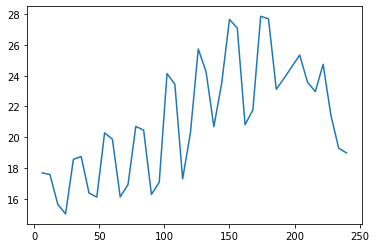

In [8]:

d['val'].plot()


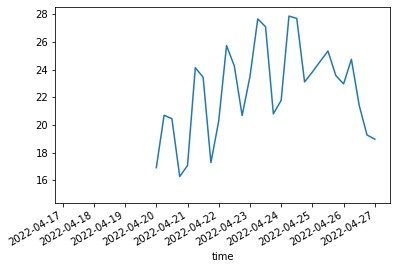

In [12]:
data['tmax2'].plot()

In [ ]:
# 核心的前端数据转后端数据的函数